# Estimating Price Elasticity of Orange Juice Demand

### Summary of Contents:
1. [Data](#data)
2. [A Blind Start: Naive ML](#naive)
3. [A Basic Attempt: Stratification](#stratification)
4. [An Intermediate Step: Partial Dependence Plot](#pdp)
5. [Parametric Heterogeneity: Double Machine Learning](#dml)
6. [Nonparametric Heterogeneity: Orthogonal Random Forest](#orf)

Note: This notebook is built off a tutorial guide built by Microsoft Azure. I added a few extra techniques which are common econometric methods for comparison. Further examples can be found here: https://notebooks.azure.com/denekew/projects/econml-samples

# 1. Data <a class="anchor" id="data"></a>

We use Dominick’s dataset, [a popular historical dataset](https://www.chicagobooth.edu/research/kilts/datasets/dominicks) of store-level orange juice prices and sales provided by University of Chicago Booth School of Business. 

<img src="https://upload.wikimedia.org/wikipedia/commons/f/fd/Orange_juice_1.jpg" width=250px/>

The dataset has ~29,000 observations and includes the store level, weekly prices and sales of 3 different brands of orange juice over 7 years in Chicago area. The dataset also contains 17 continuous and categorical variables that encode store-level customer information such as the age, log income, education level, etc, as well as brand information. We define the following variables:

* Y: Orange Juice sales (log)
* T: Price (log)
* X: Income of customers at store-level (feature of heterogeneity we want to study)
* W: Other store-level features (education, age, etc.)
* $\theta(X)$: Effect of price on sales (Orange juice elasticity)

The goal is to **learn the elasticity of orange juice as a function of income** in the presence of high-dimensional controls. In the causal inference world, this problem is popularly called the estimation of **heterogenous treatment effect**. Elasticity is the "treatment effect" because treating customers to a different price will lead to a different sales volume; it is "heterogenous" because we expect elasticity to be different across customer segments. 

Thus, we model the world as follows:
$$
\begin{align}
Y & = \theta(X) \cdot T + f(W) + \epsilon\\
T &= g(W) + \eta
\end{align}
$$
where $\epsilon, \eta$ are uncorrelated error terms.

In [33]:
# Installing packages (please add packages based in your environment)
!pip install econml

^C


In [5]:
# Helper imports
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import urllib.request 
from itertools import product
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, \
                                 MultiTaskElasticNet, MultiTaskElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels.api as sm

# EconML imports
from econml.bootstrap import BootstrapEstimator
from econml.dml import DMLCateEstimator, SparseLinearDMLCateEstimator

from econml.utilities import cross_product
from econml.ortho_forest import ContinuousTreatmentOrthoForest
from econml.utilities import WeightedModelWrapper
%matplotlib inline

In [3]:
# Import the data
file_name = "oj_large.csv"

if not os.path.isfile(file_name):
    print("Downloading file (this might take a few seconds)...")
    urllib.request.urlretrieve("https://msalicedatapublic.blob.core.windows.net/datasets/OrangeJuice/oj_large.csv", file_name)
oj_data = pd.read_csv(file_name)

## 1.1 Data Exploration

In [6]:
oj_data.head(5)

,store,brand,week,logmove,feat,price,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
0,2,tropicana,40,9.018695,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
1,2,tropicana,46,8.723231,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
2,2,tropicana,47,8.253228,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
3,2,tropicana,48,8.987197,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
4,2,tropicana,50,9.093357,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927


In [7]:
original_columns = oj_data.columns

In [8]:
oj_data.brand.unique()

array(['tropicana', 'minute.maid', 'dominicks'], dtype=object)

Text(0.5, 1.0, 'Demand vs price of OJ for different brands')

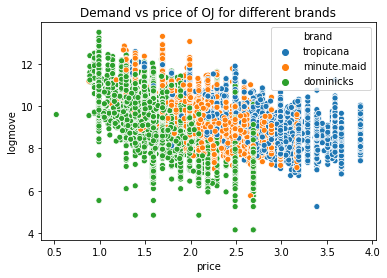

In [9]:
sns.scatterplot(x="price", y="logmove", hue="brand", data=oj_data)
plt.title("Demand vs price of OJ for different brands")

## 1.2 Data Preprocessing

In [182]:
def process_data(data):
    # Prepare data
    Y = data['logmove'].values
    T = np.log(data["price"]).values
    scaler = StandardScaler()
    W1 = scaler.fit_transform(data[[c for c in data.columns if c not in ['price', 'logmove', 'brand', 'week', 'store','INCOME']]].values)
    W2 = pd.get_dummies(data['brand'], drop_first=True).values
    W = np.concatenate([W1, W2], axis=1)
    X = data[['INCOME']].values
    return Y, T, W, X

Y, T, W, X = process_data(oj_data)

In [11]:
W.shape

(28947, 13)

In [12]:
original_columns

Index(['store', 'brand', 'week', 'logmove', 'feat', 'price', 'AGE60', 'EDUC',
       'ETHNIC', 'INCOME', 'HHLARGE', 'WORKWOM', 'HVAL150', 'SSTRDIST',
       'SSTRVOL', 'CPDIST5', 'CPWVOL5'],
      dtype='object')

In [13]:
w_columns = [c for c in original_columns if c not in ['price', 'logmove', 'brand', 'week', 'store','INCOME']]
print(w_columns)

['feat', 'AGE60', 'EDUC', 'ETHNIC', 'HHLARGE', 'WORKWOM', 'HVAL150', 'SSTRDIST', 'SSTRVOL', 'CPDIST5', 'CPWVOL5']


In [14]:
w_columns.append("brand_1")
w_columns.append("brand_2")
print(w_columns)

['feat', 'AGE60', 'EDUC', 'ETHNIC', 'HHLARGE', 'WORKWOM', 'HVAL150', 'SSTRDIST', 'SSTRVOL', 'CPDIST5', 'CPWVOL5', 'brand_1', 'brand_2']


In [15]:
## Generate test data
min_income = 10.0 
max_income = 11.1
delta = (max_income - min_income) / 100
X_test = np.arange(min_income, max_income + delta - 0.001, delta).reshape(-1, 1)

# 2. A Blind Start: Naive ML <a class="anchor" id="naive"></a>

If we didn't know anything about causal inference, we might have tried some standard ML techniques to capture the treatment effect heterogeneity. In this section, we try a naive regression model $Y \sim T$:

$$
\begin{align}
Y &= \theta(X)\cdot T+c + \epsilon \\
\theta(X)&=a+b\cdot X + \eta
\end{align}
$$
where $\epsilon, \eta$ are independent errors.

As a reminder, these are the variables:
* Y: Orange Juice sales (log)
* T: Price (log)
* X: Income of customers at store-level (feature of heterogeneity we want to study)
* W: Other store-level features (education, age, etc.)
* $\theta(X)$: Effect of price on sales (Orange juice elasticity)

Note that $\theta$ is written as a function of income as we logically expect price elasticity to be affected by income-levels. In this naive model, we assume a linear relationship which is one of the drawbacks of regression models: we have to make prior assumptions about the parametric form.

In [105]:
T_reshaped = np.reshape(T,(28947,1))

In [106]:
poly = PolynomialFeatures(1, include_bias=True)
XT_1 = cross_product(poly.fit_transform(X), T)
XT_2 = cross_product(X, poly.fit_transform(T_reshaped))

In [110]:
# Fit linear model Y ~ XT + X
model_1 = LinearRegression(fit_intercept=True)
model_1.fit(XT_1, Y)
model_1.coef_

array([-1.12055267, -0.04540197])

In [111]:
# Fit linear model Y ~ XT + T
model_2 = LinearRegression(fit_intercept=True)
model_2.fit(XT_2, Y)
model_2.coef_

array([-0.07598552, -0.15024241])

In [112]:
te_pred_1 = model_1.coef_[0] + X_test * model_1.coef_[1]

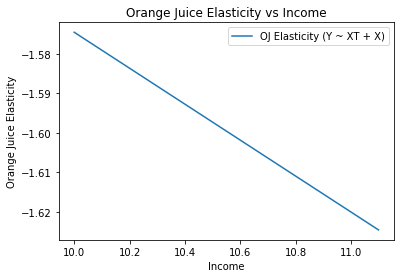

In [115]:
plt.plot(X_test, te_pred_1, label="OJ Elasticity (Y ~ XT + X)")
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

Intuitively, we expect higher income populations to be less price-sensitive and hence have larger elasticities. However, as we can see in the plot above, higher income populations appear more price-sensitive than lower income ones. That can't be right!

In the following sections, we test out other classical statistical methods, stratification and PDP, before applying more advanced methods from `econml` estimators to see if we can remedy the issue we encounter here. 

# 3. A Basic Attempt: Stratification <a class="anchor" id="stratification"></a>

One very basic attempt at controlling for this income confounder is by segmenting the dataset before performing regression. For example, we could potentially split the data into high-income and low-income stores before performing the exact same regression.

In [86]:
# Split low and high income by median

median = np.median(oj_data["price"])
low_Y, low_T, low_W, low_X = process_data(oj_data[oj_data["price"] < median])
high_Y, high_T, high_W, high_X = process_data(oj_data[oj_data["price"] >= median])

In [120]:
## Performing the same steps as regression

# Low Income
poly = PolynomialFeatures(1, include_bias=True)
low_XT = cross_product(poly.fit_transform(low_X), low_T)
low_model = LinearRegression(fit_intercept=True)
low_model.fit(low_XT, low_Y)
print(low_model.coef_)

# High Income
poly = PolynomialFeatures(1, include_bias=True)
high_XT = cross_product(poly.fit_transform(high_X), high_T)
high_model = LinearRegression(fit_intercept=True)
high_model.fit(high_XT, high_Y)
print(high_model.coef_)

[ 7.19344072 -0.84228816]
[-2.62355923  0.19961526]


In [125]:
te_pred_low = low_model.coef_[0] + X_test[X_test < 10.5] * low_model.coef_[1]
te_pred_high = high_model.coef_[0] + X_test[X_test > 10.5] * high_model.coef_[1]

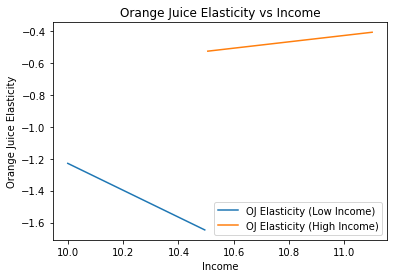

In [126]:
plt.plot(X_test[X_test < 10.5], te_pred_low, label="OJ Elasticity (Low Income)")
plt.plot(X_test[X_test > 10.5], te_pred_high, label="OJ Elasticity (High Income)")
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

We have managed to successfully obtain more logical values for elasticities between high and low income groups. Wealthier customers tend ot be less price sensitive to everyday groceries such as orange juice. 

However, stratifying the dataset has a few drawbacks:
* Wasteful treatment of dataset 
* Trade-off between granularity of heterogenous treatment effect function and statistical power. In other words, if we want to split into more granular income groups, our dataset per group becomes smaller

# 4. An Intermediate Step: Partial Dependence Plots <a class="anchor" id="pdp"></a>


In order to go beyond the parametric form of structural equations above, we can utilise very popular non-parametric methods such as Random Forest (RF). We built a combined dataset which has all the variables (XTW) and built a RF regressor to predict Y. 

Subsequently, we teased out the non-linear relationship between X and Y using partial dependence plots (PDP). PDP is an interpretable AI technique which shows the marginal effect of one or two features on a predicted outcome of a machine learning model. For a more theoretical introduction, this blog does a very good job: https://christophm.github.io/interpretable-ml-book/pdp.html

In [138]:
XTW = np.concatenate((X, np.reshape(T,(28947, 1)), W), axis = 1) 
# Concatenating all relevant features which help to predict Y, including feature under study and potential confounders
XTW.shape

(28947, 15)

In [139]:
XTW = XTW[XTW[:,1] != 0] # Remove cases where T = 0 which gives infinite elasticity

In [140]:
XTW.shape

(28942, 15)

In [144]:
elas = Y/T # elasticity based on linear model
elas = elas[elas < 1000000] # Remove cases where T = 0 which gives infinite elasticity 
model = RandomForestRegressor(max_depth=4, random_state=0, n_estimators = 500)
model.fit(XTW, elas)

C:\Users\Jian.Lim\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

**PDP Plot**

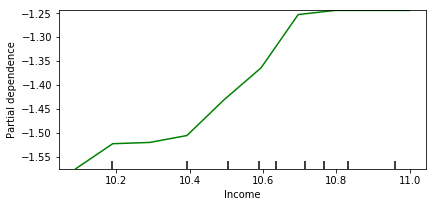

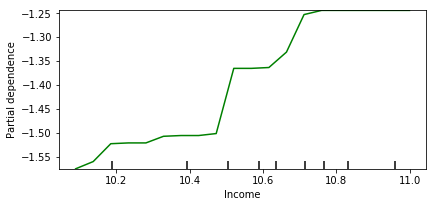

In [149]:
from sklearn.inspection import plot_partial_dependence

my_plots = plot_partial_dependence(model,       
                                   features=[0], #column numbers of plots we want to show
                                   X=XTW,   
                                   feature_names=['Income'], # labels on graphs
                                   grid_resolution=10) # number of values to plot on x axis

my_plots2 = plot_partial_dependence(model,       
                                   features=[0], #column numbers of plots we want to show
                                   X=XTW,   
                                   feature_names=['Income'], # labels on graphs
                                   grid_resolution=20) # finer granularity

We see to be getting better as the shape of price elasticity with respect to income is more logical. It monotonically increases with income and has a substantial difference for low and high income groups (remembering this is log income). 

Moreover, the elasticity levels taper off at extreme income levels which is also sensible - we do not expect elasticity to continue on decreasing or increasing indefinitely based on economic theory. A PDP plot with higher grid resolution at the bottom shows more jagged edges but this is likely just due to limited data.

**ICE Plot**

To further unravel PDP, data scientists often use Individual Conditional Expectation (ICE) plots. Whereas PDP shows the **average** of how the predictions change over one feature, ICE plots how the predictions change for each individual datapoint. In other words, PDP is an aggregated form of ICE. 


Unfortunately sklearn does not have a ICE implementation yet. The pull request is pending review, so hopefully it will be in the next sklearn update.

# 3. Parametric Heterogeneity: Double Machine Learning  <a class="anchor" id="dml"></a>

Finally, we move onto **Double Machine Learning** techniques which is one of the latest techniques from the Potential Outcomes camp of causal inference. This is a very powerful technique which allows ML practitioners to use any arbitary machine learning technique to solve causal inference problems. It also has proven statistical properties such as:
* Producing unbiased estimates of the treatment effect
* Producing asymptotically normally distributed estimates which is useful as a confidence indicator

This algorithm has been implemented as the `DMLCateEstimator` in EconML package to estimate orange juice price elasticity as a function of income. The EconML documentation provides a good summary of the theory behind the algorithm, while the original paper (https://arxiv.org/pdf/1608.00060.pdf) has all the statistical proofs.

## 3.1 Default setting: Linear heterogeneity

First, we try to estimate the heterogenous treatment effect as a linear function of income.

In [127]:
# Main imports
from econml.dml import LinearDMLCateEstimator, ForestDMLCateEstimator

est = LinearDMLCateEstimator(model_y=RandomForestRegressor(),model_t=RandomForestRegressor(),
                            featurizer=PolynomialFeatures(degree=1))
est.fit(Y, T, X, W)
te_pred=est.effect(X_test)

C:\Users\Jian.Lim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Jian.Lim\AppData\Local\Continuum\anaconda3\lib\site-packages\econml\dml.py:94: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._model.fit(self._combine(X, W, Target.shape[0]), Target)
C:\Users\Jian.Lim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Jian.Lim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in ver

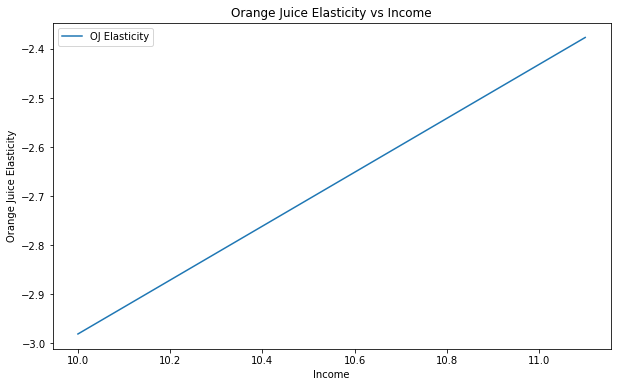

In [128]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(10,6))
plt.plot(X_test, te_pred, label="OJ Elasticity")
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

The estimates look more reasonable now! The slope has an upwards trend and the estimates are in the expected range $(-3, -2)$. Let's see what happens if we add some more structure to $\theta(X)$. 

## 3.2 Polynomial heterogeneity

In this section, we assume a polynomial form for $\theta(X)$.

In [152]:
est = LinearDMLCateEstimator(model_y=RandomForestRegressor(),model_t=RandomForestRegressor(),
                            featurizer=PolynomialFeatures(degree=3))
est.fit(Y, T, X, W)
te_pred=est.effect(X_test)

C:\Users\Jian.Lim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Jian.Lim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Jian.Lim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Jian.Lim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 t

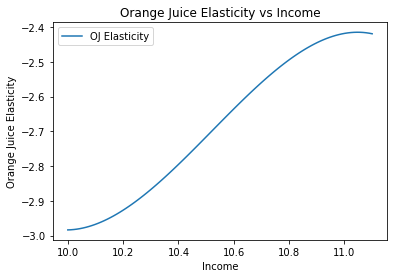

In [153]:
# Plot Orange Juice elasticity as a function of income
plt.plot(X_test, te_pred, label="OJ Elasticity")
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

As you can see above, our Polynomial degree 3 estimator is able to approximately replicate the shape of the Random Forest PDP plot above. However, the elasticities obtained through Double Machine Learning (DML) is much higher. The original DML paper shows that **DMl is bias-free** compared to classical methods. Hence, we should trust the elasticities obtained through DML more strongly.

In [154]:
# Boostrap confidence interval
boot_est = BootstrapEstimator(LinearDMLCateEstimator(model_y=RandomForestRegressor(n_estimators = 100),
                                                     model_t=RandomForestRegressor(n_estimators = 100),
                            featurizer=PolynomialFeatures(degree=3)), 
                              n_bootstrap_samples=20)
boot_est.fit(Y, T, X, W)
te_pred_interval = boot_est.effect_interval(X_test, lower=1, upper=99)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Jian.Lim\AppData\Local\Continuum\anaconda3\lib\site-packages\econml\utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.9s remaining:    0.0s
C:\Users\Jian.Lim\AppData\Local\Continuum\anaconda3\lib\site-packages\econml\utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   40.5s remaining:    0.0s
C:\Users\Jian.Lim\AppData\Local\Continuum\anaconda3\lib\site-packages\econml\utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be inval

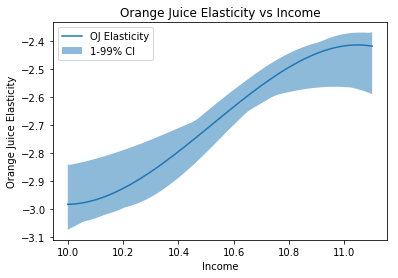

In [155]:
# Plot Orange Juice elasticity as a function of income
plt.plot(X_test.flatten(), te_pred, label="OJ Elasticity")
plt.fill_between(X_test.flatten(), te_pred_interval[0], te_pred_interval[1], alpha=.5, label="1-99% CI")
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.title("Orange Juice Elasticity vs Income")
plt.legend()
plt.show()

## 3.3 Model Selection

Here we try different polynomial degrees in our final model to compare the model performance. The score of final model can be seen as the proxy of the score of the treatment effect when we don't know the true treatment effect. We can use this function to do model selection or parameter tuning.

In [156]:
X_train, X_test, Y_train, Y_test, \
W_train, W_test, T_train, T_test = train_test_split(X, Y, W, T, test_size=0.3, random_state=42) # 42, the meaning of life

In [157]:
# We try degree = [1,2,3,4,5]
score = {}
for i in range(1,6):
    est = LinearDMLCateEstimator(model_y=RandomForestRegressor(n_estimators=100),
                           model_t=RandomForestRegressor(n_estimators=100),
                           featurizer=PolynomialFeatures(degree=i))
    est.fit(Y, T, X, W)
    score['DML polynomial degree={}'.format(i)]=est.score(Y_test, T_test, X_test, W_test)

C:\Users\Jian.Lim\AppData\Local\Continuum\anaconda3\lib\site-packages\econml\utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
C:\Users\Jian.Lim\AppData\Local\Continuum\anaconda3\lib\site-packages\econml\utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
C:\Users\Jian.Lim\AppData\Local\Continuum\anaconda3\lib\site-packages\econml\utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference will be invalid!")
C:\Users\Jian.Lim\AppData\Local\Continuum\anaconda3\lib\site-packages\econml\utilities.py:961: UserWarning: Co-variance matrix is undertermined. Inference will be invalid!
  warnings.warn("Co-variance matrix is undertermined. Inference

In [158]:
score

{'DML polynomial degree=1': 0.340430112211725,
 'DML polynomial degree=2': 0.34049401157755677,
 'DML polynomial degree=3': 0.3412606218827467,
 'DML polynomial degree=4': 0.34036357510196,
 'DML polynomial degree=5': 0.3405993629208746}

In [159]:
print("Best model selected by score: ", min(score, key=lambda x: score.get(x)))

Best model selected by score:  DML polynomial degree=4


# 4. Nonparametric Heterogeneity: Orthogonal Random Forest  <a class="anchor" id="orf"></a>

Double Machine Learning is a great technique if we have some priors on what the treatment effect function should look like, such as the parametric form. However, if we want a fully non-parametric estimation of the treatment effect, we need to use different tools. 

In this section, we apply the `ContinuousTreatmentOrthoForest` in EconML to estimate orange juice price elasticity
as a function of income. This is a fully non-parametric model based on Random Forests which was first introduced by https://arxiv.org/pdf/1806.03467.pdf.

In [217]:
# Define some parameters
n_trees = 1000
min_leaf_size = 50
max_depth = 20
subsample_ratio = 0.04
bootstrap = False

In [218]:
# Define the estimator
est_orf = ContinuousTreatmentOrthoForest(
        n_trees=n_trees, min_leaf_size=min_leaf_size, max_depth=max_depth, 
        subsample_ratio=subsample_ratio, bootstrap=bootstrap, 
        model_T=Lasso(alpha=0.1),
        model_Y=Lasso(alpha=0.1),
        model_T_final=WeightedModelWrapper(LassoCV(cv=3), sample_type="weighted"), 
        model_Y_final=WeightedModelWrapper(LassoCV(cv=3), sample_type="weighted")
       )

In [219]:
est_orf.fit(Y, T, X, W, inference = "blb")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.6s finished


In [220]:
min_income = 10.0 
max_income = 11.1
delta = (max_income - min_income) / 100
X_test = np.arange(min_income, max_income + delta - 0.001, delta).reshape(-1, 1)

In [221]:
te_pred = est_orf.const_marginal_effect(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   30.5s finished


In [222]:
# Calculate default (90%) marginal confidence intervals for the test data
te_upper, te_lower = est_orf.const_marginal_effect_interval(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   39.2s finished


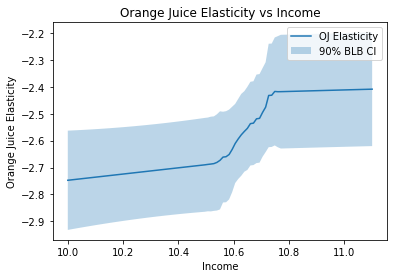

In [224]:
# Plot Orange Juice elasticity as a function of income
plt.plot(X_test.flatten(), te_pred, label="OJ Elasticity")
plt.fill_between(X_test.flatten(), te_lower, te_upper, label="90% BLB CI", alpha=0.3)
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

## Conclusion

And there it is! We now have a causal inference technique which is able to:
* Adjust for confounding to find heterogenous effect
* Able to produce a statistically-sound technique
* Able to produce a statistically-sound confidence interval